In [1]:

import os

DATA_DIR = '/kaggle/input/celeba'
print(os.listdir(DATA_DIR))

['img_align_celeba']


In [2]:
print(os.listdir(DATA_DIR+'/img_align_celeba')[:10])

['083648.jpg', '168202.jpg', '125778.jpg', '059339.jpg', '032501.jpg', '160139.jpg', '046754.jpg', '178961.jpg', '123482.jpg', '039337.jpg']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
#this command will take some time to run. after 2 min run the next command and then proceed as expected
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
#run this after 2 min as mentioned above
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

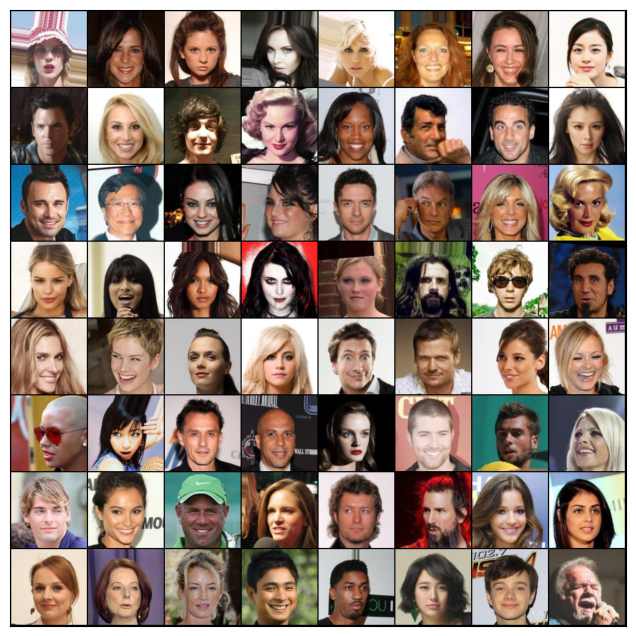

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn

In [14]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [15]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=b75285801c53baaa70ac881adac024c21ea03dae9317cfa7e29687cc53070a3a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [16]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Assuming your discriminator model is defined as above...

# Create a dummy input tensor appropriate for the input dimensions of the model
dummy_input = torch.randn(1, 3, 128, 128)

# Forward pass through the model to get the output
model_out = discriminator(dummy_input)

# Generate the graph
graph = make_dot(model_out, params=dict(list(discriminator.named_parameters()) + [('input', dummy_input)]))

# Render the graph (this will display the graph in a Jupyter notebook or similar environment)
graph.render("discriminator_model_visualization", format="png", directory="path/to/save")

# The line above saves the visualization as a PNG image in the specified directory.
# If you're running this in a notebook and just want to display the visualization, you can simply do:
# graph.view()

'path/to/save/discriminator_model_visualization.png'

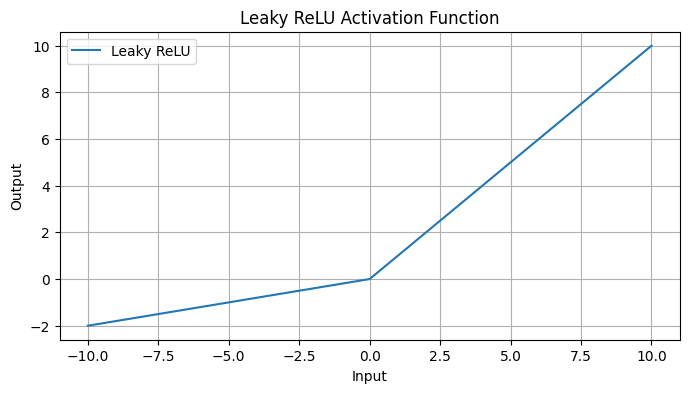

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Leaky ReLU function with a negative slope of 0.2
def leaky_relu(x, alpha=0.2):
    return np.where(x > 0, x, x * alpha)

# Generate a series of numbers from -10 to 10 for plotting
x_values = np.linspace(-10, 10, 1000)
y_values = leaky_relu(x_values)

# Plot the function
plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, label="Leaky ReLU")
plt.title("Leaky ReLU Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
discriminator = to_device(discriminator, device)

In [20]:
latent_size = 128

In [21]:
import torch.nn as nn

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)


In [22]:
import torch
from torchviz import make_dot
lat_size = 100

# Assuming your discriminator model is defined as above...

# Create a dummy input tensor appropriate for the input dimensions of the model
dummy_input = torch.randn(1, latent_size, 1, 1)

# Forward pass through the model to get the output
model_out = generator(dummy_input)

# Generate the graph
graph = make_dot(model_out, params=dict(list(generator.named_parameters()) + [('input', dummy_input)]))

# Render the graph (this will display the graph in a Jupyter notebook or similar environment)
graph.render("generator_model_visualization", format="png", directory="path/to/save")

# The line above saves the visualization as a PNG image in the specified directory.
# If you're running this in a notebook and just want to display the visualization, you can simply do:
# graph.view()


'path/to/save/generator_model_visualization.png'

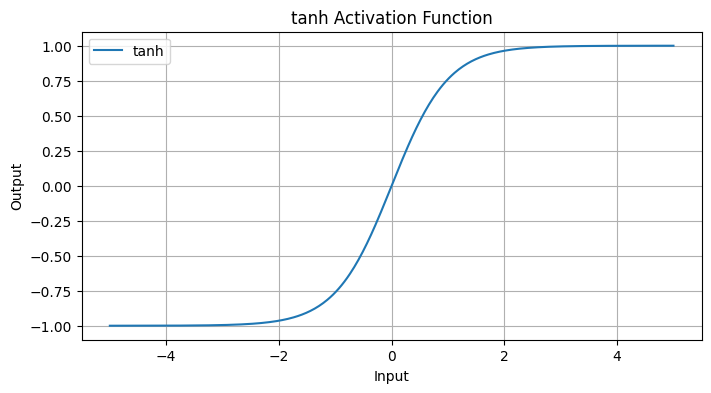

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a series of numbers from -5 to 5 for the input values
x_values = np.linspace(-5, 5, 400)
y_values = np.tanh(x_values)

# Plot the tanh function
plt.figure(figsize=(8, 4))
plt.plot(x_values, y_values, label="tanh")
plt.title("tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.grid(True)
plt.legend()
plt.show()

torch.Size([128, 3, 128, 128])


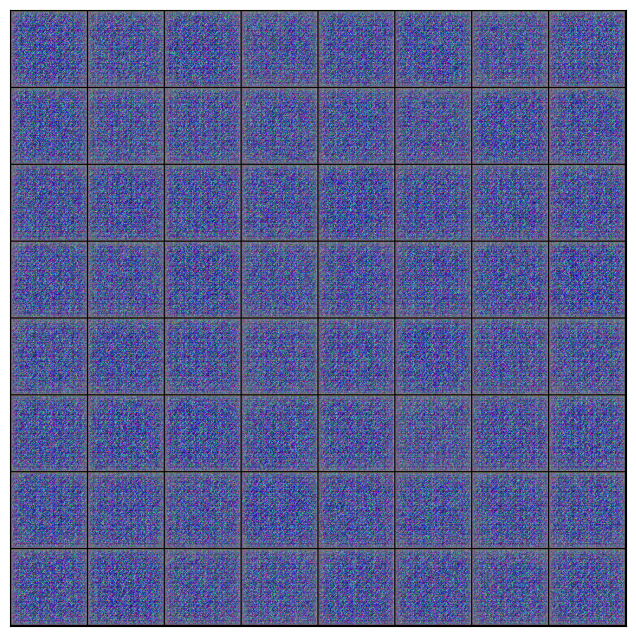

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

In [27]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [28]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


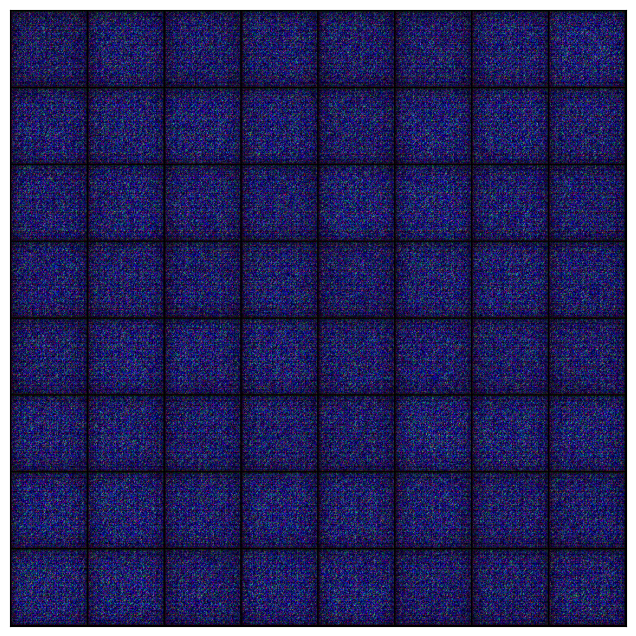

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr = 0.0003
epochs = 15

In [ ]:
#this is where the training takes place thr training will most probably stop showing at 10th 
#or 16 th epoch. but the process will be going on in the background. 
#Check Output>kaggle/working>expand>genrrated images click the refresh button and the generated images will show up.
#You can download and see how much improvement in each iteration
#after the 30th image has been generated run the next command
history = fit(epochs, lr)

  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 5.0803, loss_d: 0.8331, real_score: 0.9671, fake_score: 0.5049
Saving generated-images-0001.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 6.3482, loss_d: 0.6083, real_score: 0.6304, fake_score: 0.0046
Saving generated-images-0002.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 10.0505, loss_d: 0.4252, real_score: 0.9818, fake_score: 0.2946
Saving generated-images-0003.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 4.6057, loss_d: 0.0604, real_score: 0.9503, fake_score: 0.0064
Saving generated-images-0004.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 6.5036, loss_d: 0.0796, real_score: 0.9772, fake_score: 0.0462
Saving generated-images-0005.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 4.4181, loss_d: 0.2255, real_score: 0.8760, fake_score: 0.0457
Saving generated-images-0006.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 3.1502, loss_d: 0.3355, real_score: 0.8055, fake_score: 0.0488
Saving generated-images-0007.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 6.2669, loss_d: 0.0677, real_score: 0.9403, fake_score: 0.0032
Saving generated-images-0008.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 6.2782, loss_d: 0.0767, real_score: 0.9857, fake_score: 0.0525
Saving generated-images-0009.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 5.9005, loss_d: 0.2343, real_score: 0.8274, fake_score: 0.0089
Saving generated-images-0010.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 16.2838, loss_d: 3.1203, real_score: 1.0000, fake_score: 0.8008
Saving generated-images-0011.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 4.3134, loss_d: 0.0338, real_score: 0.9844, fake_score: 0.0169
Saving generated-images-0012.png


  0%|          | 0/3166 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 8.0123, loss_d: 0.0529, real_score: 0.9531, fake_score: 0.0006
Saving generated-images-0013.png


  0%|          | 0/3166 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

# Plotting generator and discriminator loss
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting discriminator scores
plt.figure(figsize=(10, 5))
plt.plot(real_scores, label='Real Score')
plt.plot(fake_scores, label='Fake Score')
plt.title('Discriminator Scores')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()

In [1]:
#run this after genetation
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

NameError: name 'torch' is not defined

In [ ]:
from IPython.display import Image

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()